In [1]:
import cython
import numpy as np
import TidalPy
import CyRK
print('Cython', cython.__version__)
print('TidalPy', TidalPy.__version__)
print('CyRK', CyRK.__version__)

2024-01-19 14:41:15(+00:00:49::087699) - INFO     : TidalPy initializing...
2024-01-19 14:41:15(+00:00:49::088691) - INFO     : Output directory: N:\Joe Documents\Research\Software\TidalPy\Tests\TidalPy-Run_20240119-1441
2024-01-19 14:41:15(+00:00:49::088691) - INFO     : TidalPy initialization complete.
Cython 3.0.2
TidalPy 0.5.0a5.dev42
CyRK 0.8.5


In [2]:
%load_ext cython

## Radial Solver Function

In [17]:
%%cython -a --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libc.math cimport NAN, isnan

from cpython.mem cimport PyMem_Free

import numpy as np
cimport numpy as np

from scipy.constants import G as G_

from CyRK.utils.utils cimport  allocate_mem, reallocate_mem

# Import cythonized functions
from TidalPy.utilities.math.complex cimport cf_build_dblcmplx
from TidalPy.utilities.dimensions.nondimensional cimport cf_non_dimensionalize_physicals, cf_redimensionalize_radial_functions

from TidalPy.RadialSolver.starting.driver cimport cf_find_starting_conditions
from TidalPy.RadialSolver.solutions cimport cf_find_num_solutions
from TidalPy.RadialSolver.interfaces.interfaces cimport cf_solve_upper_y_at_interface
from TidalPy.RadialSolver.interfaces.reversed cimport cf_top_to_bottom_interface_bc
from TidalPy.RadialSolver.derivatives.base cimport RadialSolverBase
from TidalPy.RadialSolver.derivatives.odes cimport cf_build_solver
from TidalPy.RadialSolver.boundaries.boundaries cimport cf_apply_surface_bc
from TidalPy.RadialSolver.collapse.collapse cimport cf_collapse_layer_solution

from libcpp cimport bool as bool_cpp_t

from TidalPy.RadialSolver.solver cimport find_love_cf

# Setup globals
cdef double G
G = G_

# Maximum size for array building
cdef size_t MAX_NUM_Y      = 6
cdef size_t MAX_NUM_Y_REAL = 2 * MAX_NUM_Y
cdef size_t MAX_NUM_SOL    = 3

cdef class RadialSolverSolution():
    
    cdef public str message
    cdef public bool_cpp_t success

    # Result structure information
    cdef size_t num_ys
    cdef size_t num_slices
    cdef size_t total_size
    cdef size_t num_ytypes
    cdef tuple ytypes

    # Result pointers and data
    cdef double complex* full_solution_ptr
    cdef double complex[::1] full_solution_view

    # Love number information
    cdef double complex* complex_love_ptr
    cdef double complex[::1] complex_love_view

    def __init__(
            self,
            size_t num_slices,
            tuple solve_for,
            size_t num_ytypes
            ):

        # loop indicies
        cdef size_t i
        cdef size_t love_array_size

        # Initialize pointers
        self.full_solution_ptr = NULL
        self.complex_love_ptr = NULL

        # Initialize status
        self.message = 'RadialSolverSolution has not had its status set.'
        self.success = False

        # Store number of solution types
        self.num_ytypes = num_ytypes
        self.ytypes = solve_for
        
        # Store size information
        self.num_slices = num_slices
        self.total_size = MAX_NUM_Y * self.num_slices * self.num_ytypes

        # Have the radial solver take control of the full solution memory
        self.full_solution_ptr = <double complex*> allocate_mem(
            self.total_size * sizeof(double complex),
            'full_solution_ptr (RadialSolverSolution; init)'
            )
        if not (self.full_solution_ptr is NULL):
            self.full_solution_view = <double complex[:self.total_size]> self.full_solution_ptr
        
        # Set all values of the solution array to NANs. This ensures that if there is a problem with the solver then
        #  the solutions will be defined (but nan).
        for i in range(self.total_size):
            self.full_solution_ptr[i] = NAN
        
        # Initialize Love numbers (3 love numbers for each requested y-type)
        # Love numbers are stored (k, h, l)_ytype0, (k, h, l)_ytype1, (k, h, l)_ytype2, ...
        love_array_size = 3 * self.num_ytypes
        self.complex_love_ptr = <double complex*> allocate_mem(
            love_array_size * sizeof(double complex),
            'complex_love_ptr (RadialSolverSolution; init)'
            )
        if not (self.complex_love_ptr is NULL):
            self.complex_love_view = <double complex[:love_array_size]> self.complex_love_ptr
        for i in range(love_array_size):
            self.complex_love_ptr[i] = NAN

    @property
    def result(self):
        """ Return result array. """
        return np.ascontiguousarray(
            self.full_solution_view,
            dtype=np.complex128
            ).reshape((self.num_slices, self.num_ytypes * MAX_NUM_Y)).T
    
    @property
    def love(self):
        """ Return all complex love numbers. """
        return np.ascontiguousarray(
            self.complex_love_view,
            dtype=np.complex128
        ).reshape((self.num_ytypes, 3))

    @property
    def k(self):
        """ Tidal Love number k. """
        return np.ascontiguousarray(
            self.complex_love_view[0::3],
            dtype=np.complex128
        )

    @property
    def h(self):
        """ Tidal Love number h. """
        return np.ascontiguousarray(
            self.complex_love_view[1::3],
            dtype=np.complex128
        )
    
    @property
    def l(self):
        """ Tidal Shida number l. """
        return np.ascontiguousarray(
            self.complex_love_view[2::3],
            dtype=np.complex128
        )
    
    def __len__(self):
        """Return number of solution types."""
        return <Py_ssize_t>self.num_ytypes
    
    def __getitem__(self, str ytype_name):
        """Get a specific solution type array."""
        
        cdef size_t i
        cdef size_t requested_sol_num = 0
        cdef bool_cpp_t found = False
        cdef str sol_test_name
        for i in range(self.num_ytypes):
            sol_test_name = self.ytypes[i]
            if sol_test_name == ytype_name:
                requested_sol_num = i
                found = True
                break
        if not found:
            raise AttributeError('Unknown solution type requested. Key must match names passed to radial_solver "solve_for" argument and be lower case.')
        
        # Slice the result and return only the requested solution type.
        return self.result[MAX_NUM_Y * (requested_sol_num): MAX_NUM_Y * (requested_sol_num + 1)]

    def __dealloc__(self):

        # The RadialSolverSolution class has full control of the solution so it is responsible for releasing its memory.
        if not (self.full_solution_ptr is NULL):
            PyMem_Free(self.full_solution_ptr)


cdef RadialSolverSolution cf_radial_solver(
        const double[:] radius_array,
        const double[:] density_array,
        const double[:] gravity_array,
        const double[:] bulk_modulus_array,
        const double complex[:] complex_shear_modulus_array,
        double frequency,
        double planet_bulk_density,
        tuple is_solid_by_layer,
        tuple is_static_by_layer,
        tuple is_incompressible_by_layer,
        tuple upper_radius_by_layer,
        unsigned int degree_l = 2,
        tuple solve_for = None,
        bool_cpp_t use_kamata = False,
        int integration_method = 1,
        double integration_rtol = 1.0e-4,
        double integration_atol = 1.0e-12,
        bool_cpp_t scale_rtols_by_layer_type = True,
        size_t max_num_steps = 500_000,
        size_t expected_size = 500,
        size_t max_ram_MB = 500,
        double max_step = 0,
        bool_cpp_t limit_solution_to_radius = True,
        bool_cpp_t nondimensionalize = True,
        bool_cpp_t verbose = False,
        bool_cpp_t raise_on_fail = False
        ):
    """
    Radial solver for 
    """
    # General indexing
    # Indexing for: Layer | Solution | ys | slices | solutions
    cdef size_t layer_i
    cdef size_t slice_i
    cdef size_t top_slice_i
    # Indexing for: Solution | ys | ytypes
    cdef unsigned char solution_i
    cdef unsigned char y_i
    cdef unsigned char ytype_i
    cdef unsigned char lhs_y_index

    # Type conversions
    cdef double degree_l_dbl = <double>degree_l

    # Pull out key information
    cdef double radius_planet
    cdef size_t num_layers
    cdef size_t num_interfaces
    cdef size_t total_slices

    total_slices   = len(radius_array)
    top_slice_i    = total_slices - 1
    radius_planet  = radius_array[total_slices - 1]
    num_layers     = len(is_solid_by_layer)
    num_interfaces = num_layers - 1
    print('DEBUG!! ', total_slices, radius_planet, num_layers)

    # Ensure there is at least one layer.
    if num_layers <= 0:
        raise AttributeError('Radial solver requires at least one layer.')

    # Ensure there are enough slices for radial interpolations.
    if total_slices <= (3 * num_layers):
        raise AttributeError('Radial solver requires at least 3 radial slices per layer (ideally >= 10 per).')

    # Copy the radial data into new pointers so the values can be manipulated inside this function.
    # Store all double-sized data in one large array.
    cdef double* radial_double_data_ptr = <double *> allocate_mem(
        4 * total_slices * sizeof(double),
        'radial_double_data_ptr (radial_solver; init)'
        )

    # Create user-friendly pointers to access blocks of that array
    cdef double* radius_array_ptr  = &radial_double_data_ptr[0]
    cdef double* density_array_ptr = &radial_double_data_ptr[total_slices]
    cdef double* gravity_array_ptr = &radial_double_data_ptr[2 * total_slices]
    cdef double* bulk_array_ptr    = &radial_double_data_ptr[3 * total_slices]

    # Opt: The data above is not stored in the most memory-efficient way since at each slice we will want all of:
    #  radius, density, gravity, etc. But since those are stored on separate rows, we have to go all the way to the end
    #  of a row to get the next item at slice_i. A fortran memory layout would be more efficient here.

    # Repeat for double complex-sized data.
    cdef double complex* cmplx_shear_array_ptr = <double complex *> allocate_mem(
        total_slices * sizeof(double complex),
        'cmplx_shear_array_ptr (radial_solver; init)'
        )

    # Populate the arrays (making a copy of values)
    for slice_i in range(total_slices):
        radius_array_ptr[slice_i]      = radius_array[slice_i]
        density_array_ptr[slice_i]     = density_array[slice_i]
        gravity_array_ptr[slice_i]     = gravity_array[slice_i]
        bulk_array_ptr[slice_i]        = bulk_modulus_array[slice_i]
        cmplx_shear_array_ptr[slice_i] = complex_shear_modulus_array[slice_i]

    # Non-dimensionalize inputs
    cdef double G_to_use = NAN
    cdef double frequency_to_use = NAN
    if nondimensionalize:
        cf_non_dimensionalize_physicals(
            total_slices,
            frequency,
            radius_planet,
            planet_bulk_density,
            radius_array_ptr,
            density_array_ptr,
            gravity_array_ptr,
            bulk_array_ptr,
            cmplx_shear_array_ptr,
            &frequency_to_use,
            &G_to_use
            )
        
        # Ensure that no errors occured during the non-dim process
        if isnan(frequency_to_use) or isnan(G_to_use):
            raise ValueError('NaNs encountered after non-dimensionalize call.')
    else:
        # Leave inputs alone.
        G_to_use         = G
        frequency_to_use = frequency

    cdef double surface_gravity = gravity_array_ptr[total_slices - 1]

    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    # The [5] represents the maximum number of solvers that can be invoked with a single call to radial_solver
    cdef size_t max_num_solutions = 5
    cdef size_t num_ytypes = 1
    cdef str solver_name
    # 15 = 5 (max_num_solutions) * 3 (number of surface conditions)
    cdef double[15] boundary_conditions
    cdef double* bc_pointer = &boundary_conditions[0]

    if solve_for is None:
        # Assume we are solving for tides
        if nondimensionalize:
            bc_pointer[0] = 0.
            bc_pointer[1] = 0.
            bc_pointer[2] = (2. * degree_l_dbl + 1.) / 1.
        else:
            bc_pointer[0] = 0.
            bc_pointer[1] = 0.
            bc_pointer[2] = (2. * degree_l_dbl + 1.) / radius_planet
        solve_for = ('tidal',)
    else:
        # Use user input
        num_ytypes = len(solve_for)
        if num_ytypes > max_num_solutions:
            raise AttributeError(f'Unsupported number of solvers requested (max is {max_num_solutions}).')
        
        # Parse user input for the types of solvers that should be used.
        ytype_i = 0
        while num_ytypes > ytype_i:
            solver_name = solve_for[ytype_i]
            if solver_name.lower() == 'tidal':
                if nondimensionalize:
                    bc_pointer[ytype_i * 3 + 0] = 0.
                    bc_pointer[ytype_i * 3 + 1] = 0.
                    bc_pointer[ytype_i * 3 + 2] = (2. * degree_l_dbl + 1.) / 1.
                else:
                    bc_pointer[ytype_i * 3 + 0] = 0.
                    bc_pointer[ytype_i * 3 + 1] = 0.
                    bc_pointer[ytype_i * 3 + 2] = (2. * degree_l_dbl + 1.) / radius_planet
            elif solver_name.lower() == 'loading':
                if nondimensionalize:
                    bc_pointer[ytype_i * 3 + 0] = -(2. * degree_l_dbl + 1.) / 3.
                    bc_pointer[ytype_i * 3 + 1] = 0.
                    bc_pointer[ytype_i * 3 + 2] = (2. * degree_l_dbl + 1.) / 1.
                else:
                    bc_pointer[ytype_i * 3 + 0] = -(2. * degree_l_dbl + 1.) * planet_bulk_density / 3.
                    bc_pointer[ytype_i * 3 + 1] = 0.
                    bc_pointer[ytype_i * 3 + 2] = (2. * degree_l_dbl + 1.) / radius_planet
            elif solver_name.lower() == 'free':
                bc_pointer[ytype_i * 3 + 0] = 0.
                bc_pointer[ytype_i * 3 + 1] = 0.
                bc_pointer[ytype_i * 3 + 2] = 0.
            else:
                raise NotImplementedError(f'Requested solver, {solver_name}, has not been implemented.\n\tSupported solvers are: tidal, loading, free.')
            ytype_i += 1

    # Integration information
    # Max step size
    cdef double max_step_touse
    cdef bool_cpp_t max_step_from_arrays
    max_step_from_arrays = False
    if max_step == 0:
        # If max_step is zero use the array information to determine max_step_size
        max_step_from_arrays = True
    else:
        # Otherwise use user input.
        max_step_touse = max_step

    # Setup tolerance arrays
    # For simplicity just make these all as large as the maximum number of ys.
    # Maximum number of ys = 6. Then 2x for conversion from complex to real
    cdef double[12] rtols_array
    cdef double* rtols_ptr = &rtols_array[0]
    cdef double[12] atols_array
    cdef double* atols_ptr = &atols_array[0]

    # Create storage for flags and information about each layer.
    cdef size_t* layer_int_data_ptr = <size_t *> allocate_mem(
        3 * num_layers * sizeof(size_t),
        'layer_int_data_ptr (radial_solver; init)'
        )

    cdef size_t* num_solutions_by_layer_ptr = &layer_int_data_ptr[0]
    cdef size_t* start_index_by_layer_ptr   = &layer_int_data_ptr[num_layers]
    cdef size_t* num_slices_by_layer_ptr    = &layer_int_data_ptr[2 * num_layers]

    # Unpack inefficient user-provided tuples into bool array
    cdef bool_cpp_t* layer_bool_data_ptr = <bool_cpp_t *> allocate_mem(
        3 * num_layers * sizeof(bool_cpp_t),
        'layer_bool_data_ptr (radial_solver; init)'
        )

    cdef bool_cpp_t* is_solid_by_layer_ptr          = &layer_bool_data_ptr[0]
    cdef bool_cpp_t* is_static_by_layer_ptr         = &layer_bool_data_ptr[num_layers]
    cdef bool_cpp_t* is_incompressible_by_layer_ptr = &layer_bool_data_ptr[2 * num_layers]

    # Opt: The bools above could be stores in a single char variable (per layer).
    #  Eg., 0x00 All false, 0x01 is solid, 0x10 is static and liquid, 0x11 is static and solid, etc.

    cdef bool_cpp_t layer_is_solid
    cdef bool_cpp_t layer_is_static
    cdef bool_cpp_t layer_is_incomp
    cdef bool_cpp_t layer_below_is_solid
    cdef bool_cpp_t layer_below_is_static
    cdef bool_cpp_t layer_below_is_incomp
    cdef double layer_upper_radius, radius_check
    cdef double layer_rtol_real
    cdef double layer_rtol_imag
    cdef double layer_atol_real
    cdef double layer_atol_imag
    cdef size_t layer_slices
    cdef unsigned char num_sols
    cdef unsigned char num_ys
    cdef unsigned char num_ys_dbl
    cdef unsigned char layer_below_num_sols
    cdef unsigned char layer_below_num_ys

    for layer_i in range(num_layers):
        # Pull out information on this layer
        layer_is_solid     = is_solid_by_layer[layer_i]
        layer_is_static    = is_static_by_layer[layer_i]
        layer_is_incomp    = is_incompressible_by_layer[layer_i]
        layer_upper_radius = upper_radius_by_layer[layer_i]
        
        # Make any dimension corrections
        if nondimensionalize:
            layer_upper_radius = layer_upper_radius / radius_planet

        # Once the tuples are unpacked once store their values so we don't have to mess with them again.
        is_solid_by_layer_ptr[layer_i]          = layer_is_solid
        is_static_by_layer_ptr[layer_i]         = layer_is_static
        is_incompressible_by_layer_ptr[layer_i] = layer_is_incomp

        # Find number of solutions based on this layer's assumptions
        num_sols = cf_find_num_solutions(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp
            )
        num_ys = 2 * num_sols
        num_solutions_by_layer_ptr[layer_i] = num_sols

        # Determine how many slices are in this layer
        if layer_i == 0:
            # First layer starts at 0.
            start_index_by_layer_ptr[0] = 0
        else:
            # Not first layer. Starting point is based on number of slices in previous layer.
            start_index_by_layer_ptr[layer_i] = \
                start_index_by_layer_ptr[layer_i - 1] + num_slices_by_layer_ptr[layer_i - 1]

        layer_slices = 0
        for slice_i in range(start_index_by_layer_ptr[layer_i], total_slices):
            radius_check = radius_array_ptr[slice_i]
            print(layer_slices, slice_i, radius_check, layer_upper_radius)
            if radius_check > layer_upper_radius:
                # We have passed this layer.
                break
            layer_slices += 1
        if layer_slices <= 3:
            print('DEBUG!! ', layer_slices, radius_check, layer_upper_radius)
            raise ValueError('At least three layer slices per layer are required\n\tTry using more slices in the'
                             'input arrays.')
        num_slices_by_layer_ptr[layer_i] = layer_slices

    # We have all the size information needed to build storage pointers
    # Main storage pointer is setup like [layer_i][solution_i][y_i + r_i]
    cdef double complex*** main_storage = <double complex ***> allocate_mem(
        num_layers * sizeof(double complex**),
        'main_storage (radial_solver; init)'
        )

    cdef double complex** storage_by_solution = NULL
    cdef double complex* storage_by_y = NULL

    for layer_i in range(num_layers):
        num_sols     = num_solutions_by_layer_ptr[layer_i]
        layer_slices = num_slices_by_layer_ptr[layer_i]
        # Number of ys = 2x num sols
        num_ys = 2 * num_sols

        storage_by_solution = <double complex **> allocate_mem(
            num_sols * sizeof(double complex*), 
            'storage_by_solution (radial_solver; init)'
            ) 

        for solution_i in range(num_sols):
            storage_by_y = <double complex *> allocate_mem(
                layer_slices * num_ys * sizeof(double complex),
                'storage_by_y (radial_solver; init)'
                )

            storage_by_solution[solution_i] = storage_by_y
            storage_by_y = NULL
        main_storage[layer_i] = storage_by_solution
        storage_by_solution = NULL

    # Create storage for uppermost ys for each solution. We don't know how many solutions or ys per layer so assume the
    #  worst.
    cdef double complex[36] uppermost_y_per_solution
    cdef double complex* uppermost_y_per_solution_ptr = &uppermost_y_per_solution[0]

    # Layer specific pointers; set the size based on the layer with the most slices.
    cdef double* layer_radius_ptr
    cdef double* layer_density_ptr
    cdef double* layer_gravity_ptr
    cdef double* layer_bulk_mod_ptr
    cdef double complex* layer_shear_mod_ptr

    # Properties at top and bottom of layer
    cdef double radius_lower, radius_upper
    cdef double density_lower, density_upper
    cdef double gravity_lower, gravity_upper
    cdef double bulk_lower
    cdef double complex shear_lower
    cdef tuple radial_span

    # Properties at interfaces between layers
    cdef double static_liquid_density
    cdef double interface_gravity
    cdef double last_layer_upper_gravity, last_layer_upper_density

    # Starting solutions (initial conditions / lower boundary conditions)
    # Allocate memory for the initial value arrays now. We don't know the number of solutions or ys. But the max number
    #  is not all that different from the min. So it is more efficient to assume the largest size.
    # Largest size = 6 (ys) x 3 (sols) = 18
    # For the "only_real" this is further multiplied by 2 since we convert the number of _complex_ ys to 2x _real_ ys
    cdef double complex[18] initial_y
    cdef double complex* initial_y_ptr = &initial_y[0]
    cdef double[36] initial_y_only_real
    cdef double* initial_y_only_real_ptr = &initial_y_only_real[0]
    cdef bool_cpp_t starting_y_check = False

    # Intermediate values
    cdef double complex dcomplex_tmp

    # Solver class
    cdef RadialSolverBase solver
    cdef double* solver_solution_ptr = NULL
    cdef bool_cpp_t cysolver_setup = False

    # Feedback
    cdef str feedback_str
    cdef bool_cpp_t error
    feedback_str = 'Starting integration'
    if verbose:
        print(feedback_str)
    error = False
    cdef size_t start_index

    # No matter the results of the integration, we know the shape and size of the final solution.
    # The number of rows will depend on if the user wants to simultaneously calculate loading Love numbers.
    cdef size_t num_output_ys = MAX_NUM_Y * num_ytypes
    
    # Build final output solution
    cdef RadialSolverSolution solution = RadialSolverSolution(total_slices, solve_for, num_ytypes)

    # Get a reference pointer to solution array
    cdef double complex* solution_ptr = solution.full_solution_ptr

    # During collapse, variables for the layer above the target one are used. Declare these and preset them.
    cdef double layer_above_lower_gravity
    cdef double layer_above_lower_density
    cdef double liquid_density_at_interface
    cdef bool_cpp_t layer_above_is_solid
    cdef bool_cpp_t layer_above_is_static
    cdef bool_cpp_t layer_above_is_incomp

    # The constant vectors are the same size as the number of solutions in the layer. But since the largest they can
    #  ever be is 3, it is more efficient to just preallocate them on the stack rather than dynamically allocate them
    #  on the heap.
    cdef double complex[3] constant_vector
    cdef double complex* constant_vector_ptr = &constant_vector[0]
    cdef double complex[3] layer_above_constant_vector
    cdef double complex* layer_above_constant_vector_ptr = &layer_above_constant_vector[0]
    cdef double complex[6] surface_solutions
    cdef double complex* surface_solutions_ptr = &surface_solutions[0]

    # OPT: Could reuse some of these variables so there are not so many being allocated for this function.
    cdef double complex y4_frac_1, y4_frac_2
    cdef double complex gamma_1, gamma_2
    cdef double complex lower_s1y1, lower_s1y2, lower_s1y5, lower_s1y6
    cdef double complex lower_s2y1, lower_s2y2, lower_s2y5, lower_s2y6
    cdef double complex lambda_1, lambda_2

    # Variables used to solve the linear equation at the planet's surface.
    # Info = flag set by the solver. Set equal to -999. This will indicate that the solver has not been called yet.
    cdef int bc_solution_info = -999

    # Shifted or reversed indices used during collapse.
    cdef size_t layer_i_reversed

    try:
        for layer_i in range(num_layers):
            # Get layer's index information
            start_index  = start_index_by_layer_ptr[layer_i]
            layer_slices = num_slices_by_layer_ptr[layer_i]

            # Get solution and y information
            num_sols   = num_solutions_by_layer_ptr[layer_i]
            num_ys     = 2 * num_sols
            num_ys_dbl = 2 * num_ys

            # Setup pointer array slices starting at this layer's beginning
            layer_radius_ptr    = &radius_array_ptr[start_index]
            layer_density_ptr   = &density_array_ptr[start_index]
            layer_gravity_ptr   = &gravity_array_ptr[start_index]
            layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
            layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

            # Get physical parameters at the top and bottom of the layer
            radius_lower  = layer_radius_ptr[0]
            density_lower = layer_density_ptr[0]
            gravity_lower = layer_gravity_ptr[0]
            bulk_lower    = layer_bulk_mod_ptr[0]
            shear_lower   = layer_shear_mod_ptr[0]
            radius_upper  = layer_radius_ptr[layer_slices - 1]
            density_upper = layer_density_ptr[layer_slices - 1]
            gravity_upper = layer_gravity_ptr[layer_slices - 1]

            # Determine max step size (if not provided by user)
            if max_step_from_arrays:
                # Maximum step size during integration can not exceed the average radial slice size.
                max_step_touse = (radius_upper - radius_lower) / <double>layer_slices

            # Get assumptions for layer
            layer_is_solid  = is_solid_by_layer_ptr[layer_i]
            layer_is_static = is_static_by_layer_ptr[layer_i]
            layer_is_incomp = is_incompressible_by_layer_ptr[layer_i]

            # Determine rtols and atols for this layer.
            # Scale rtols by layer type
            y_i = 0
            while num_ys > y_i:
                # Default is that each layer's rtol and atol equal user input.
                # TODO: Change up the tolerance scaling between real and imaginary?
                layer_rtol_real = integration_rtol
                layer_rtol_imag = integration_rtol
                layer_atol_real = integration_atol
                layer_atol_imag = integration_atol

                if scale_rtols_by_layer_type:
                    # Certain layer assumptions can affect solution stability so use additional scales on the relevant rtols
                    # TODO test that these scales are the best.
                    if layer_is_solid:
                        # Scale y2 and y3 by 0.1
                        if (y_i == 1) or (y_i == 2):
                            # Scale both the real and imaginary portions by the same amount.
                            layer_rtol_real *= 0.1
                            layer_rtol_imag *= 0.1
                    else:
                        if not layer_is_static:
                            # Scale dynamic liquid layer's y2 by additional 0.01.
                            if (y_i == 1):
                                # Scale both the real and imaginary portions by the same amount.
                                layer_rtol_real *= 0.01
                                layer_rtol_imag *= 0.01
                # Populate rtol and atol pointers.
                rtols_ptr[2 * y_i]     = layer_rtol_real
                rtols_ptr[2 * y_i + 1] = layer_rtol_imag
                atols_ptr[2 * y_i]     = layer_atol_real
                atols_ptr[2 * y_i + 1] = layer_atol_imag

                y_i += 1
            # Find initial conditions for each solution at the base of this layer.
            radial_span = (radius_lower, radius_upper)
            if layer_i == 0:
                # Use initial condition function
                cf_find_starting_conditions(
                    layer_is_solid,
                    layer_is_static,
                    layer_is_incomp,
                    use_kamata,
                    frequency_to_use,
                    radius_lower,
                    density_lower,
                    bulk_lower,
                    shear_lower,
                    degree_l,
                    G_to_use,
                    MAX_NUM_Y, 
                    initial_y_ptr,  # Modified Variable
                    starting_y_check
                    )
            else:
                layer_below_is_solid  = is_solid_by_layer_ptr[layer_i - 1]
                layer_below_is_static = is_static_by_layer_ptr[layer_i - 1]
                layer_below_is_incomp = is_incompressible_by_layer_ptr[layer_i - 1]

                # Find gravity at the base interface using bottom of this layer and top of previous.
                interface_gravity = 0.5 * (gravity_lower + last_layer_upper_gravity)

                # Find the density needed for some initial conditions.
                if layer_is_solid and layer_below_is_solid:
                    # Both layers are solid. A liquid interface density is not needed.
                    static_liquid_density = NAN
                elif not layer_is_solid and layer_below_is_solid:
                    # Layer below is solid, this layer is liquid. Use its density.
                    static_liquid_density = density_lower
                elif layer_is_solid and not layer_below_is_solid:
                    # Layer below is liquid, this layer is solid. Use layer below's density.
                    static_liquid_density = last_layer_upper_density
                else:
                    # Both layers are liquid. Choose the layer's density which is static.
                    if layer_is_static and layer_below_is_static:
                        # Both layers are static.
                        # TODO: Not sure what to do here so just use this layer's density.
                        static_liquid_density = density_lower
                    elif layer_is_static and not layer_below_is_static:
                        # This layer is static, one below is not. Use this layer's density
                        static_liquid_density = density_lower
                    elif not layer_is_static and layer_below_is_static:
                        # This layer is dynamic, layer below is static. Use layer below's density
                        static_liquid_density = last_layer_upper_density
                    else:
                        # Both layers are dynamic. Static liquid density is not needed.
                        static_liquid_density = NAN

                # Find the starting values for this layer using the results a the top of the previous layer + an interface
                #  function.
                cf_solve_upper_y_at_interface(
                    uppermost_y_per_solution_ptr,
                    initial_y_ptr,
                    layer_below_num_sols,
                    num_sols,
                    layer_below_num_ys,
                    num_ys,
                    layer_below_is_solid,
                    layer_below_is_static,
                    layer_below_is_incomp,
                    layer_is_solid,
                    layer_is_static,
                    layer_is_incomp,
                    interface_gravity,
                    static_liquid_density,
                    G_to_use
                    )

            # Change initial conditions into 2x real values instead of complex for integration
            solution_i = 0
            while num_sols > solution_i:
                y_i = 0
                while num_ys > y_i:
                    dcomplex_tmp = initial_y_ptr[solution_i * MAX_NUM_Y + y_i]
                    initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL + 2 * y_i]     = dcomplex_tmp.real
                    initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL + 2 * y_i + 1] = dcomplex_tmp.imag
                    y_i += 1
                solution_i += 1

            # Build solver instance
            solver = cf_build_solver(
                layer_is_solid,
                layer_is_static,
                layer_is_incomp,
                layer_slices,
                2 * num_ys,  # Solver needs to know how many ys it is working with. 2x ys in this case.
                layer_radius_ptr,
                layer_density_ptr,
                layer_gravity_ptr,
                layer_bulk_mod_ptr,
                layer_shear_mod_ptr,
                frequency_to_use,
                degree_l,
                G_to_use,
                radial_span,
                &initial_y_only_real_ptr[0],  # Start the pointer at the beginning of the array
                atols_ptr,
                rtols_ptr,
                integration_method,
                max_step_touse,
                max_num_steps,
                expected_size,
                max_ram_MB,
                limit_solution_to_radius
                )
            cysolver_setup = True

            # Get storage pointer for this layer
            storage_by_solution = main_storage[layer_i]

            # Solve for each solution
            solution_i = 0
            while num_sols > solution_i:
                if solution_i > 0:
                    # Reset solver with new initial condition (this is already done for j==0)
                    # This pointer has already been passed to the solver during initialization but we need the values at
                    #  the next solution. Pass new pointer at that address.
                    solver.change_y0_pointer(
                        &initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL],
                        auto_reset_state=False
                        )

                ###### Integrate! #######
                solver._solve(reset=True)
                #########################

                # Check for problems
                if not solver.success:
                    # Problem with integration.
                    feedback_str = f'Integration problem at layer {layer_i}; solution {solution_i}:\n\t{solver.message}'
                    if verbose:
                        print(feedback_str)
                    if raise_on_fail:
                        raise RuntimeError(feedback_str)
                    error = True
                    break

                # If no problems, store results.
                solver_solution_ptr = solver.solution_y_ptr
                # Need to make a copy because the solver pointers will be reallocated during the next solution.
                # Get storage pointer for this solution
                storage_by_y = storage_by_solution[solution_i]
                y_i = 0
                while num_ys > y_i:
                    for slice_i in range(layer_slices):
                        # Convert 2x real ys to 1x complex ys
                        storage_by_y[num_ys * slice_i + y_i] = cf_build_dblcmplx(
                            solver_solution_ptr[num_ys_dbl * slice_i + (2 * y_i)],
                            solver_solution_ptr[num_ys_dbl * slice_i + (2 * y_i) + 1]
                            )

                    # Store top most result for initial condition for the next layer
                    # slice_i should already be set to the top of this layer after the end of the previous loop.
                    uppermost_y_per_solution_ptr[solution_i * MAX_NUM_Y + y_i] = storage_by_y[num_ys * slice_i + y_i]
                    
                    y_i += 1
                
                # Ready for next solution
                solution_i += 1

            if error:
                # Error was encountered during integration
                break

            # Prepare for next layer
            layer_below_num_sols = num_sols
            layer_below_num_ys   = num_ys
            last_layer_upper_gravity = gravity_upper
            last_layer_upper_density = density_upper
            del solver
            cysolver_setup = False

        if error:
            feedback_str = 'Integration failed.'
            if verbose:
                print(feedback_str)
            if raise_on_fail:
                raise RuntimeError(feedback_str)

        else:
            feedback_str = 'Integration completed for all layers. Beginning solution collapse.'

            ytype_i = 0
            while num_ytypes > ytype_i:
                feedback_str = f'Collapsing radial solutions for "{ytype_i}" solver.'

                # Reset variables for this solver
                bc_solution_info = -999
                constant_vector_ptr[0] = NAN
                constant_vector_ptr[1] = NAN
                constant_vector_ptr[2] = NAN
                layer_above_lower_gravity   = 0.
                layer_above_lower_density   = 0.
                liquid_density_at_interface = 0.
                layer_above_is_solid        = False
                layer_above_is_static       = False
                layer_above_is_incomp       = False

                if verbose:
                    print(feedback_str)
                # Collapse the multiple solutions for each layer into one final combined solution.

                # Work from the surface to the core.
                for layer_i in range(num_layers):
                    layer_i_reversed = num_layers - (layer_i + 1)

                    # Pull out layer information.
                    start_index  = start_index_by_layer_ptr[layer_i_reversed]
                    layer_slices = num_slices_by_layer_ptr[layer_i_reversed]

                    # Get solution and y information
                    num_sols     = num_solutions_by_layer_ptr[layer_i_reversed]
                    num_ys       = 2 * num_sols

                    # Setup pointer array slices starting at this layer's beginning
                    layer_radius_ptr    = &radius_array_ptr[start_index]
                    layer_density_ptr   = &density_array_ptr[start_index]
                    layer_gravity_ptr   = &gravity_array_ptr[start_index]
                    layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
                    layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

                    # Get physical parameters at the top and bottom of the layer
                    radius_lower  = layer_radius_ptr[0]
                    density_lower = layer_density_ptr[0]
                    gravity_lower = layer_gravity_ptr[0]
                    bulk_lower    = layer_bulk_mod_ptr[0]
                    shear_lower   = layer_shear_mod_ptr[0]
                    radius_upper  = layer_radius_ptr[layer_slices - 1]
                    density_upper = layer_density_ptr[layer_slices - 1]
                    gravity_upper = layer_gravity_ptr[layer_slices - 1]

                    # Get assumptions for layer
                    layer_is_solid  = is_solid_by_layer_ptr[layer_i_reversed]
                    layer_is_static = is_static_by_layer_ptr[layer_i_reversed]
                    layer_is_incomp = is_incompressible_by_layer_ptr[layer_i_reversed]

                    # Get full solutions for this layer
                    storage_by_solution = main_storage[layer_i_reversed]

                    # Get value at the top of the layer
                    solution_i = 0 
                    while num_sols > solution_i:
                        y_i = 0
                        while num_ys > y_i:
                            uppermost_y_per_solution_ptr[solution_i * MAX_NUM_Y + y_i] = \
                                storage_by_solution[solution_i][(layer_slices - 1) * num_ys + y_i]
                            y_i += 1
                        solution_i += 1

                    if layer_i == 0:
                        # Working on surface (uppermost) layer -- Apply surface boundary conditions.
                        cf_apply_surface_bc(
                            constant_vector_ptr,  # Modified Variable
                            &bc_solution_info,  # Modified Variable
                            bc_pointer,
                            uppermost_y_per_solution_ptr,
                            surface_gravity,
                            G_to_use,
                            num_sols,
                            MAX_NUM_Y,
                            ytype_i,
                            layer_is_solid,
                            layer_is_static,
                            layer_is_incomp
                            )

                        # Check that the boundary condition was successfully applied.
                        if bc_solution_info != 0:
                            feedback_str = \
                                (f'Error encountered while applying surface boundary condition. ZGESV code: {bc_solution_info}'
                                f'\nThe solutions may not be valid at the surface.')
                            if verbose:
                                print(feedback_str)
                            if raise_on_fail:
                                raise RuntimeError(feedback_str)
                            error = True
                            break
                    else:
                        # Working on interior layers. Will need to find the constants of integration based on the layer above.

                        cf_top_to_bottom_interface_bc(
                            constant_vector_ptr,  # Modified Variable
                            layer_above_constant_vector_ptr,
                            uppermost_y_per_solution_ptr,
                            gravity_upper, layer_above_lower_gravity,
                            density_upper, layer_above_lower_density,
                            layer_is_solid, layer_above_is_solid,
                            layer_is_static, layer_above_is_static,
                            layer_is_incomp, layer_above_is_incomp,
                            num_sols, MAX_NUM_Y
                            )

                    # Use constant vectors to find the full y from all of the solutions in this layer
                    cf_collapse_layer_solution(
                        solution_ptr,  # Modified Variable
                        constant_vector_ptr,
                        storage_by_solution,
                        layer_radius_ptr,
                        layer_density_ptr,
                        layer_gravity_ptr,
                        frequency_to_use,
                        start_index,
                        layer_slices,
                        num_sols,
                        MAX_NUM_Y,
                        num_ys,
                        num_output_ys,
                        ytype_i,
                        layer_is_solid,
                        layer_is_static,
                        layer_is_incomp
                        )

                    # Setup for next layer
                    layer_above_lower_gravity = gravity_lower
                    layer_above_lower_density = density_lower
                    layer_above_is_solid      = layer_is_solid
                    layer_above_is_static     = layer_is_static
                    layer_above_is_incomp     = layer_is_incomp

                    if num_sols == 1:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = NAN
                        layer_above_constant_vector_ptr[2] = NAN
                    elif num_sols == 2:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = constant_vector_ptr[1]
                        layer_above_constant_vector_ptr[2] = NAN
                    elif num_sols == 3:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = constant_vector_ptr[1]
                        layer_above_constant_vector_ptr[2] = constant_vector_ptr[2]
                
                # Ready for next y-type
                ytype_i += 1

            # Calculate Love numbers and install in final solution.
            # First find the solution at the planet's surface.
            for ytype_i in range(num_ytypes):
                for y_i in range(MAX_NUM_Y):
                    lhs_y_index = ytype_i * MAX_NUM_Y + y_i
                    surface_solutions_ptr[y_i] = solution_ptr[top_slice_i * num_output_ys + lhs_y_index]
                
                # Solve Love numbers for this y-type.
                find_love_cf(&solution.complex_love_ptr[ytype_i * 3], surface_solutions_ptr, surface_gravity)

    finally:
        # Free memory
        if cysolver_setup:
            del solver

        # Release radial property pointers
        if not (radial_double_data_ptr is NULL):
            radius_array_ptr  = NULL
            density_array_ptr = NULL
            gravity_array_ptr = NULL
            bulk_array_ptr    = NULL
            PyMem_Free(radial_double_data_ptr)
            radial_double_data_ptr = NULL
        if not (cmplx_shear_array_ptr is NULL):
            PyMem_Free(cmplx_shear_array_ptr)
            cmplx_shear_array_ptr = NULL

        # Deconstruct main solution pointer
        # Main storage pointers are structured like [layer_i][solution_i][y_i + slice_i]
        # Then main storage
        if not (main_storage is NULL):
            storage_by_solution = NULL
            storage_by_y = NULL
            for layer_i in range(num_layers):
                num_sols = num_solutions_by_layer_ptr[layer_i]
                if not (main_storage[layer_i] is NULL):
                    solution_i = 0
                    while num_sols > solution_i:
                        if not (main_storage[layer_i][solution_i] is NULL):
                            PyMem_Free(main_storage[layer_i][solution_i])
                            main_storage[layer_i][solution_i] = NULL
                        solution_i += 1
                    
                    PyMem_Free(main_storage[layer_i])
                    main_storage[layer_i] = NULL
            PyMem_Free(main_storage)
            main_storage = NULL

        # Release layer information pointers
        if not (layer_int_data_ptr is NULL):
            num_solutions_by_layer_ptr = NULL
            start_index_by_layer_ptr = NULL
            num_slices_by_layer_ptr = NULL
            PyMem_Free(layer_int_data_ptr)
            layer_int_data_ptr = NULL
        
        if not (layer_bool_data_ptr is NULL):
            is_solid_by_layer_ptr = NULL
            is_static_by_layer_ptr = NULL
            is_incompressible_by_layer_ptr = NULL
            PyMem_Free(layer_bool_data_ptr)
            layer_bool_data_ptr = NULL

    # Update solution status and return
    if not error:
        # Radial solver completed successfully.
        if nondimensionalize:
            # Redimensionalize the solution 
            cf_redimensionalize_radial_functions(
                solution_ptr,
                radius_planet,
                planet_bulk_density,
                total_slices,
                num_ytypes)
        solution.success = True
        solution.message = 'RadialSolver completed without any noted issues.'
    else:
        solution.success = False
        solution.message = feedback_str

    return solution


def radial_solver(
        const double[:] radius_array,
        const double[:] density_array,
        const double[:] gravity_array,
        const double[:] bulk_modulus_array,
        const double complex[:] complex_shear_modulus_array,
        double frequency,
        double planet_bulk_density,
        tuple is_solid_by_layer,
        tuple is_static_by_layer,
        tuple is_incompressible_by_layer,
        tuple upper_radius_by_layer,
        unsigned int degree_l = 2,
        tuple solve_for = None,
        bool_cpp_t use_kamata = False,
        int integration_method = 1,
        double integration_rtol = 1.0e-4,
        double integration_atol = 1.0e-12,
        bool_cpp_t scale_rtols_by_layer_type = True,
        size_t max_num_steps = 500_000,
        size_t expected_size = 500,
        size_t max_ram_MB = 500,
        double max_step = 0,
        bool_cpp_t limit_solution_to_radius = True,
        bool_cpp_t nondimensionalize = True,
        bool_cpp_t verbose = False,
        bool_cpp_t raise_on_fail = False
        ):
    """
    Solves the viscoelastic-gravitational problem for a planet comprised of solid and liquid layers.

    See Takeuchi and Saito (1972) for more details on this method.

    Parameters
    ----------
    radius_array : np.ndarray[dtype=np.float64]
        Radius values defined at slices throughout the planet [m].
    density_array : np.ndarray[dtype=np.float64]
        Density at each radius [kg m-3].
    gravity_array : np.ndarray[dtype=np.float64]
        Acceleration due to gravity at each radius [m-2].
    bulk_modulus_array : np.ndarray[dtype=np.float64]
        Bulk modulus at each radius [Pa].
    complex_shear_modulus_array : np.ndarray[dtype=np.complex128]
        Complex shear modulus at each radius [Pa].
        This should be the result of applying a rheological model to the static shear modulus, viscosity, and
        forcing frequency.
    frequency : float64
        Forcing frequency [rad s-1]
    planet_bulk_density : float64
        Bulk density of the planet [kg m-3].
    is_solid_by_layer : tuple[bool, ...] (Size = number of layers)
        Flag declaring if each layer is solid (True) or liquid (False).
    is_static_by_layer : tuple[bool, ...] (Size = number of layers)
        Flag declaring if each layer uses the static (True) or dynamic (False) assumption.
    is_incompressible_by_layer : tuple[bool, ...] (Size = number of layers)
        Flag declaring if each layer is incompressible (True) or compressible (False).
    upper_radius_by_layer : tuple[float64, ...] (Size = number of layers)
        Tuple of the upper radius of each layer.
        Used to determine physical structure of planet.
    degree_l : uint32, default=2
        Harmonic degree.
    solve_for : tuple[str, ...] (Size = number of requested solutions), default=None
        RadialSolver allows multiple solutions to be solved simultaneously, avoiding repeated integration.
        This parameter is a tuple of requested solutions. If `None`, then only "tidal" will be solved for.
        Options that are currently supported (note these are case sensitive):
            - "tidal": Tidal forcing boundary conditions.
            - "loading": Surface loading boundary conditions.
            - "free": Free surface boundary conditions.
        For example, if you want the tidal and loading solutions then you can set "solve_for=('tidal', 'loading')".
    use_kamata : bool, default=False
        If True, then the starting solution at the core will be based on equations from Kamata et al (2015; JGR:P)
        Otherwise, starting solution will be based on Takeuchi and Saito (1972)
    integration_method : int32, default=1
        Which CyRK integration protocol should be used. Options that are currently available are:
            - 0: Runge-Kutta 2(3)
            - 1: Runge-Kutta 4(5)
            - 2: Runge-Kutta / DOP 8(5/3)
    integration_rtol : float64, default=1.0e-4
        Relative integration tolerance. Lower tolerance will lead to more precise results at increased computation.
    integration_atol : float64, default=1.0e-12
        Absolute integration tolerance (when solution is near 0).
    scale_rtols_by_layer_type : bool, default=True
        If True, then each layer will be imparted with a different relative tolerance. Liquid layers will have a lower
        rtol which has been found to improve stability.
    max_num_steps : uint32, default=500,000
        Maximum number of integration steps allowed before solver forces a failed result.
        Useful to set to a lower number if running many calls that may be exploring an unstable parameter space for
        example, during a MCMC run.
    expected_size : uint32, default=500
        Anticipated number of integration steps that will be required per solution. Tweaking this may have a minor
        impact on performance. It is advised to leave it between 200--1000.
        Setting it too low can lead to bad performance.
    max_ram_MB : uint32, default=500
        Maximum amount of RAM in MB the integrator is allowed (ignoring some housekeeping usage).
        The integrator will use this value and the "max_num_steps" to determine a true limit on the maximum number
        steps allowed (picking the lower value.). If system RAM is limited (or if multiple RadialSolvers will run in
        parallel) it maybe worth setting this lower than the default.
        The default of 500MB is equivalent to a max_num_steps ~ 5 Mllion.
    max_step : float64, default=0
        Maximum step size the adaptive step size integrator is allowed to take. 
        Setting to 0 (default) will tell the integrator to determine an ideal max step size.
    limit_solution_to_radius : bool, default=True
        If True, then the solution will be limited to the points passed by the radius array.
    nondimensionalize : bool, default=True
        If Ture, then inputs will be non-dimensionalized before integration is performed.
        Results will be redimensionalized before being returned.
    verbose : bool, default=False
        If True, then additioal information will be printed to the terminal during the solution. 
    raise_on_fail : bool, default=False
        If Ture, then the solver will raise an exception if integration was not successful. By default RadialSolver
        fails silently. 

    Returns
    -------
    solution : RadialSolverSolution
        Solution to the viscoelastic-gravitational problem inside a planet.
        Solution attributes:
            - solution.results : complex128, shape=(6 * num_ytypes, n_slice)
                Numerical solution throughout the planet.
            - solution.success : bool
                Flag if integration and subsequent collapse occured without error.
            - solution.message : str
                Feedback string useful for debugging.
    """
    
    return cf_radial_solver(
            radius_array,
            density_array,
            gravity_array,
            bulk_modulus_array,
            complex_shear_modulus_array,
            frequency,
            planet_bulk_density,
            is_solid_by_layer,
            is_static_by_layer,
            is_incompressible_by_layer,
            upper_radius_by_layer,
            degree_l,
            solve_for,
            use_kamata,
            integration_method,
            integration_rtol,
            integration_atol,
            scale_rtols_by_layer_type,
            max_num_steps,
            expected_size,
            max_ram_MB,
            max_step,
            limit_solution_to_radius,
            nondimensionalize,
            verbose,
            raise_on_fail)


Content of stdout:
_cython_magic_c0f89be3ca493640d1c71b59d761dbd1575100a4.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_c0f89be3ca493640d1c71b59d761dbd1575100a4.cpp(24594): warning C4267: '=': conversion from 'size_t' to 'unsigned char', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_c0f89be3ca493640d1c71b59d761dbd1575100a4.cpp(24887): warning C4267: '=': conversion from 'size_t' to 'unsigned char', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_c0f89be3ca493640d1c71b59d761dbd1575100a4.cpp(25209): warning C4267: '=': conversion from 'size_t' to 'unsigned char', possible loss of data
C:\Users\joepr\.ipython\cython\_cython_magic_c0f89be3ca493640d1c71b59d761dbd1575100a4.cpp(26812): warning C4267: '=': conversion from 'size_t' to 'un

## Homogen Solid

In [7]:
%load_ext line_profiler

In [8]:
%lprun -u 1e-6 -f cf_radial_solver cf_radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = True,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = False,raise_on_fail = False)

Start
Starting integration
Collapsing radial solutions for "0" solver.
True
RadialSolver completed without any noted issues.


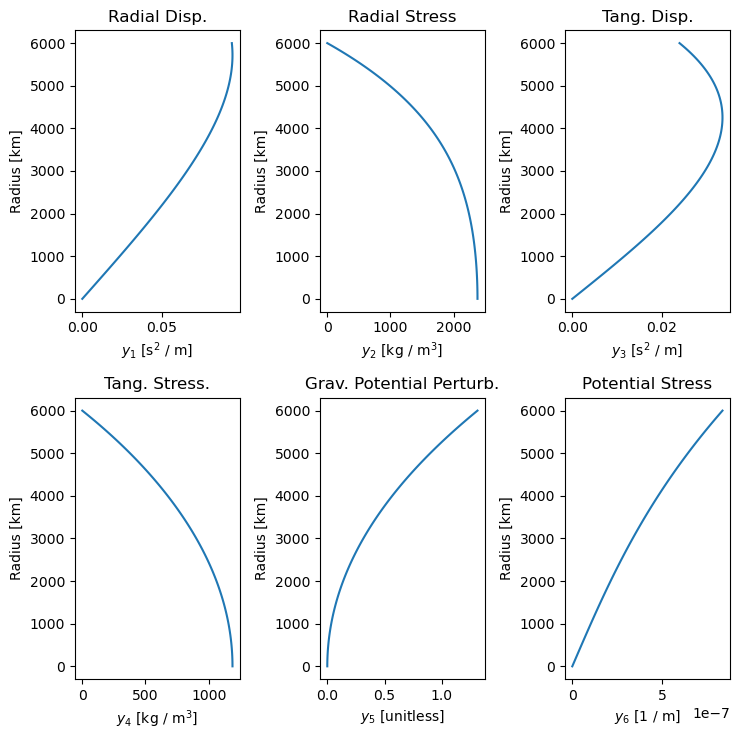

In [10]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
# frequency = 0.00001
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)

density_array = 3500. * np.ones_like(radius_array)

bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)

viscosity_array = 1.0e20 * np.ones_like(radius_array)

shear_array = 5.0e10 * np.ones_like(radius_array)

result = np.empty((6, N), dtype=np.complex128, order='C')

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (True,)
is_static_by_layer = (False,)
is_incompressible_by_layer = (False,)
indicies = (radius_array >= 0.,)
upper_radius_by_layer = (radius_array[-1],)

print('Start')

result = radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = True,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = True,raise_on_fail = False)
print(result.success)
print(result.message)
_ = yplot(result.result, radius_array)


In [5]:
print(result.k)
print(result.h)
print(result.l)
print()
print(result.love)

[0.31237705-6.41952434e-05j]
[0.55334883-0.0001098j]
[0.14093689-3.01518993e-05j]

[[0.31237705-6.41952434e-05j 0.55334883-1.09800270e-04j
  0.14093689-3.01518993e-05j]]


In [27]:
""" Benchmarks `TidalPy.radial_solver.numerical` against ALMA-3.

Please see `alma_benchmark.txt` for information on how the benchmark results were computed with ALMA.
"""

import numpy as np
import pytest

from TidalPy.constants import G
from TidalPy.utilities.spherical_helper.mass import calculate_mass_gravity_arrays
from TidalPy.rheology.complex_compliance.compliance_models import newton, maxwell

alma_results = {
    # Stored by degree l and then (k, h, l)
    2: (
        0.57287771E+00 + 1.0j * -0.27261877E-01,
        0.15454185E+01 + 1.0j * -0.73834870E-01,
        0.35239092E+00 + 1.0j * -0.32514922E-01
    ),
    3: (
        0.34660691E+00 + 1.0j * -0.22053380E-01,
        0.13145408E+01 + 1.0j * -0.83998514E-01,
        0.93226357E-01 + 1.0j * -0.14550079E-01
    ),
    4: (
        0.24671503E+00 + 1.0j * -0.23684639E-01,
        0.12075623E+01 + 1.0j * -0.11626871E+00,
        0.18763758E-01 + 1.0j * -0.74398705E-02
    ),
    5: (
        0.18915107E+00 + 1.0j * -0.29118169E-01,
        0.11352567E+01 + 1.0j * -0.17506812E+00,
        -0.82419358E-02 + 1.0j * -0.27305465E-02
    ),
    }

# Frequency settings
period = 10**-3  # kyrs
# Convert period to seconds
period_yr  = period * 1000.
period_sec = period_yr * 3.154e7
# Convert to frequency
frequency = 2 * np.pi / period_sec

# Layer Structure
planet_r = 252.e3
crust_r  = 252.e3
ocean_r  = 210.e3
core_r   = 190.e3

N = 100
radius_array = np.linspace(0.1, planet_r, N)
crust_index = radius_array > ocean_r
ocean_index = np.logical_and(radius_array > core_r, radius_array <= ocean_r)
core_index  = radius_array <= core_r
viscosity_array = np.empty_like(radius_array)
viscosity_array[core_index]  = 1.e17
viscosity_array[ocean_index] = 1.e04
viscosity_array[crust_index] = 1.e13
shear_array = np.empty_like(radius_array)
shear_array[core_index]  = 1.00e11
shear_array[ocean_index] = 0.00e00
shear_array[crust_index] = 4.00e09
density_array = np.empty_like(radius_array)
core_density = 2.400e3
ocean_density = 1.000e3
crust_density = 0.950e3
density_array[core_index]  = core_density
density_array[ocean_index] = ocean_density
density_array[crust_index] = crust_density
complex_shear = np.empty(radius_array.shape, dtype=np.complex128)
complex_shear[core_index]  = maxwell(frequency, shear_array[core_index]**(-1), viscosity_array[core_index])**(-1)
complex_shear[ocean_index] = newton(frequency, shear_array[ocean_index]**(-1), viscosity_array[ocean_index])**(-1)
complex_shear[crust_index] = maxwell(frequency, shear_array[crust_index]**(-1), viscosity_array[crust_index])**(-1)
# ALMA using an incompressible model. Fake that with a high bulk.
bulk_array = 1.0e15 * np.ones_like(radius_array)

# Find volume fracs
pi43 = (4. / 3.) * np.pi
planet_v = pi43 * planet_r**3
core_vfrac = pi43 * radius_array[core_index][-1]**3 / planet_v
ocean_vfrac = pi43 * (radius_array[ocean_index][-1]**3 - radius_array[core_index][-1]**3) / planet_v
crust_vfrac = pi43 * (radius_array[crust_index][-1]**3 - radius_array[ocean_index][-1]**3) / planet_v
planet_bulk_density = core_density * core_vfrac + ocean_density * ocean_vfrac + crust_density * crust_vfrac

volume_array, mass_array, gravity_array = \
    calculate_mass_gravity_arrays(radius_array, density_array, gravity_constant=G)

# Setup TidalPy's layer flags
layer_indices   = (core_index, ocean_index, crust_index)
is_solid_by_layer  = (True, False, True)
is_static_by_layer = (False, False, False)
is_incompressible_by_layer = (True, True, True)
upper_radius_by_layer = (core_r, ocean_r, crust_r)

@pytest.mark.parametrize('degree_l', (2, 3))
def test_radial_solver_alma_compare(degree_l):
    """ Compare TidalPy's `radial_solver` to ALMA for an Enceladus-like planet. """
    success_threshold_real = 0.05
    success_threshold_imag = 0.10

    integration_rtol = 1.0e-4
    integration_atol = 1.0e-10

    # Pull out ALMA results
    alma_k, alma_h, alma_l = alma_results[degree_l]

    # Calculate solution using the radial solver
    solution = radial_solver(
        radius_array,
        density_array,
        gravity_array,
        bulk_array,
        complex_shear,
        frequency,
        planet_bulk_density,
        is_solid_by_layer,
        is_static_by_layer,
        is_incompressible_by_layer,
        upper_radius_by_layer,
        degree_l=degree_l,
        solve_for=None,
        use_kamata=True,
        integration_method=1,
        integration_rtol=integration_rtol,
        integration_atol=integration_atol,
        scale_rtols_by_layer_type=True,
        max_num_steps=500_000,
        expected_size=500,
        max_ram_MB=500,
        max_step=0,
        limit_solution_to_radius=True,
        nondimensionalize=True,
        verbose=False,
        raise_on_fail=False)
    
    print(solution.success)
    assert solution.success

    # LEFT OFF
    # tidal_y = radial_solver(
    #         radius=radius_array, shear_modulus=complex_shear, bulk_modulus=bulk_array,
    #         density=density_array, gravity=gravity_array, frequency=frequency, planet_bulk_density=planet_bulk_density,
    #         is_solid_by_layer=is_solid_by_layer,
    #         is_static_by_layer=layer_is_static,
    #         indices_by_layer=layer_indices,
    #         order_l=order_l,
    #         surface_boundary_condition=None, solve_load_numbers=False,
    #         use_kamata=True,
    #         integrator='numba', integration_method='RK45',
    #         integration_rtol=integration_rtol, integration_atol=integration_atol,
    #         verbose=False, nondimensionalize=True, incompressible=True
    #         )
    tidalpy_k = solution.k[0]
    tidalpy_h = solution.h[0]
    tidalpy_l = solution.l[0]
    
    print('\n\n\n')

    for tpy, alma in ((tidalpy_k, alma_k), (tidalpy_h, alma_h), (tidalpy_l, alma_l)):
        tpy_real  = np.real(tpy)
        tpy_imag  = np.imag(tpy)
        alma_real = np.real(alma)
        alma_imag = np.imag(alma)

        # Calculate percent difference
        real_pctdiff = (2. * (tpy_real - alma_real) / (tpy_real + alma_real))
        imag_pctdiff = (2. * (tpy_imag - alma_imag) / (tpy_imag + alma_imag))
        
        print(real_pctdiff)
        print(imag_pctdiff)

        assert np.abs(real_pctdiff) <= success_threshold_real
        assert np.abs(imag_pctdiff) <= success_threshold_imag

test_radial_solver_alma_compare(2)

DEBUG!!  100 252000.0 3
0 0 3.9682539682539683e-07 0.753968253968254
1 1 0.010101402918069585 0.753968253968254
2 2 0.020202409010742346 0.753968253968254
3 3 0.030303415103415103 0.753968253968254
4 4 0.040404421196087864 0.753968253968254
5 5 0.050505427288760625 0.753968253968254
6 6 0.06060643338143338 0.753968253968254
7 7 0.07070743947410613 0.753968253968254
8 8 0.0808084455667789 0.753968253968254
9 9 0.09090945165945165 0.753968253968254
10 10 0.10101045775212442 0.753968253968254
11 11 0.11111146384479717 0.753968253968254
12 12 0.12121246993746992 0.753968253968254
13 13 0.1313134760301427 0.753968253968254
14 14 0.14141448212281543 0.753968253968254
15 15 0.15151548821548821 0.753968253968254
16 16 0.16161649430816097 0.753968253968254
17 17 0.1717175004008337 0.753968253968254
18 18 0.18181850649350648 0.753968253968254
19 19 0.19191951258617923 0.753968253968254
20 20 0.202020518678852 0.753968253968254
21 21 0.21212152477152474 0.753968253968254
22 22 0.22222253086419752

C:\Users\joepr\AppData\Local\Temp\ipykernel_19508\1839054661.py:73: RuntimeWarning: divide by zero encountered in reciprocal
  complex_shear[ocean_index] = newton(frequency, shear_array[ocean_index]**(-1), viscosity_array[ocean_index])**(-1)
C:\Users\joepr\AppData\Local\Temp\ipykernel_19508\1839054661.py:73: RuntimeWarning: invalid value encountered in reciprocal
  complex_shear[ocean_index] = newton(frequency, shear_array[ocean_index]**(-1), viscosity_array[ocean_index])**(-1)


AssertionError: 

In [8]:
layer_indices

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, Fal

In [ ]:
from scipy.constants import G as G_

solution_dim = radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = True,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = False,raise_on_fail = False)

solution_nodim = radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = True,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = True,verbose = False,raise_on_fail = False)

solution_redim = np.copy(solution_nodim.result)

second2_conversion = 1. / (np.pi * G_ * planet_bulk_density)
mass_conversion = planet_bulk_density * radius_array[-1]**3
length_conversion = radius_array[-1]

#    y1, y3 are the radial and tangential displacements with units of [s2 m-1]
#    y2, y4 are the radial and tangential stresses with units of [kg m-3]
#    y5 is the tidal potential which is unitless and thus needs no conversion.
#    y6 is a "potential stress" with units of [m-1]
solution_redim[0] *= (second2_conversion / length_conversion)
solution_redim[2] *= (second2_conversion / length_conversion)
solution_redim[1] *= (mass_conversion / length_conversion**3)
solution_redim[3] *= (mass_conversion / length_conversion**3)
solution_redim[4] *= 1
solution_redim[5] *= (1. / length_conversion)

_ = yplot([solution_dim.result, solution_redim], [radius_array, radius_array])


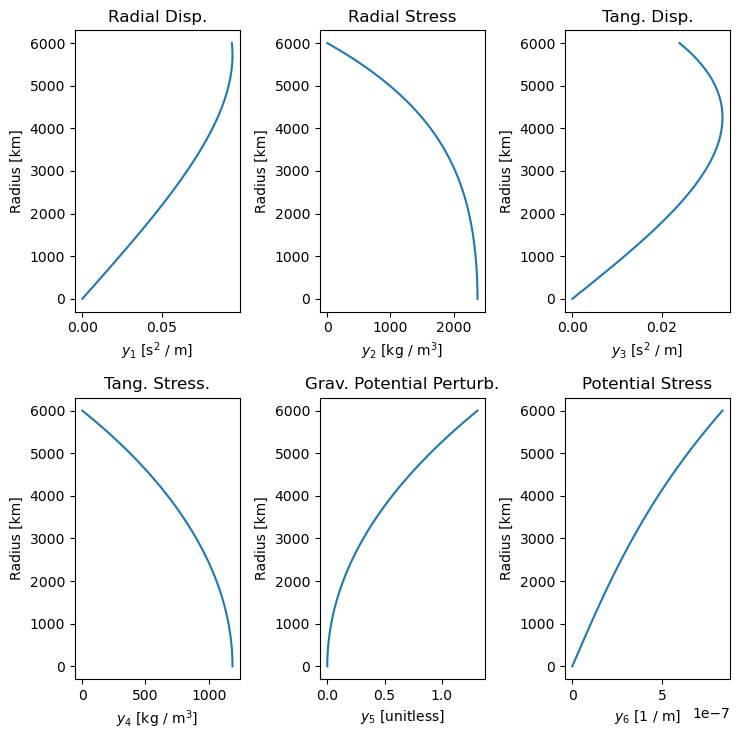

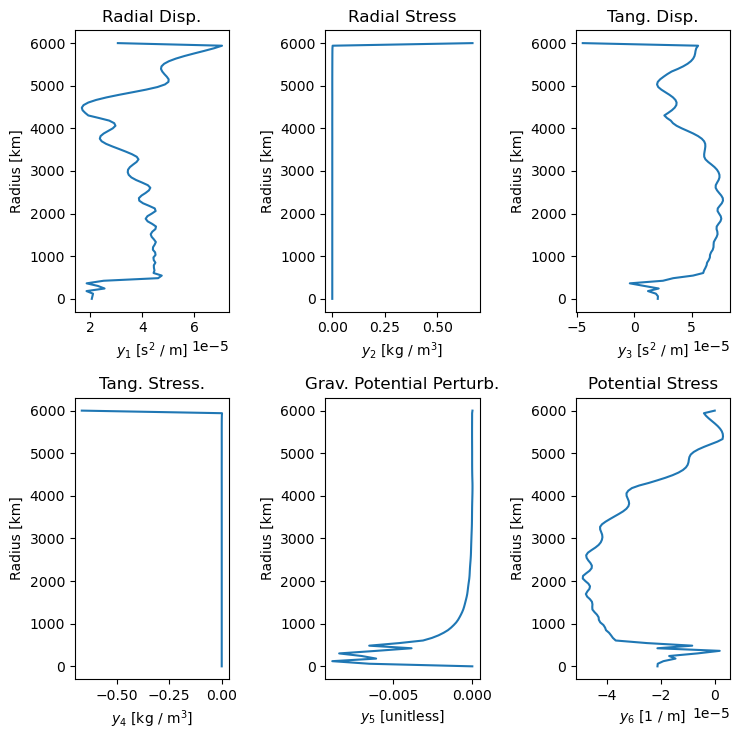

In [15]:
from TidalPy.radial_solver.numerical import radial_solver as radial_solver_old

indicies = (radius_array>=0.,)

out_old = radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = True,integration_method = 'rk45',integration_rtol = 1.0e-4,integration_atol = 1.0e-12,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot(2 * (out_old - result.result) / (out_old + result.result) , radius_array)

In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [54]:
# OLD (Not using NonDim):
# 312ms, 311ms, 298ms
# 297ms
# >> Different inputs
# 47.4ms; 47.2ms; 47.7ms
# 41.4ms; 41.4ms; 41.1ms
%timeit radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = True,integration_method = 'rk45',integration_rtol = 1.0e-4,integration_atol = 1.0e-12,nondimensionalize = False)

40.7 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
# NEW (Not using NonDim):
# 4.93ms, 4.9ms
# 2.57ms, 2.33ms
# 2.42ms
# New model / inputs -- 
# 3.92ms, 3.66ms
# 1.67ms; 1.73ms
%timeit radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = True,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = True,raise_on_fail = False)

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration (#=1). Consider increasing "expected_size".
Layer 0, Solution 0 grew arrays during integration

2.95 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Liquid-Solid

In [10]:
%lprun -u 1e-6 -f cf_radial_solver cf_radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = True,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = False,raise_on_fail = False)

Number of growths = 0.
Number of growths = 0.
Number of growths = 0.
Number of growths = 0.


True
RadialSolver completed without any noted issues.


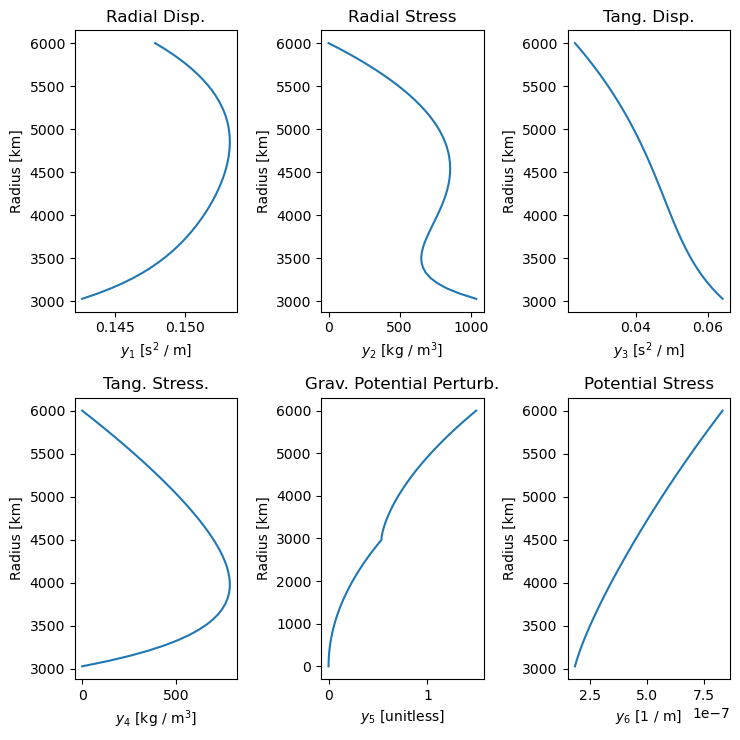

In [51]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
# frequency = 0.01
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)
CMB_radius = radius_array[-1] / 2.

density_array = 3500. * np.ones_like(radius_array)
density_array[radius_array <= CMB_radius] = 6000.

bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)
bulk_modulus_array[radius_array <= CMB_radius] = 5.0e11

viscosity_array = 1.0e20 * np.ones_like(radius_array)
viscosity_array[radius_array <= CMB_radius] = 1.0e15

shear_array = 5.0e10 * np.ones_like(radius_array)
shear_array[radius_array <= CMB_radius] = 0.

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (False, True,)
is_static_by_layer = (True, False,)
is_incompressible_by_layer = (False, False,)
indicies = (radius_array <= CMB_radius, radius_array > CMB_radius)
upper_radius_by_layer = (CMB_radius, radius_array[-1],)

result = radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = True,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = False,raise_on_fail = False)
print(result.success)
print(result.message)
_ = yplot(result.result, radius_array)


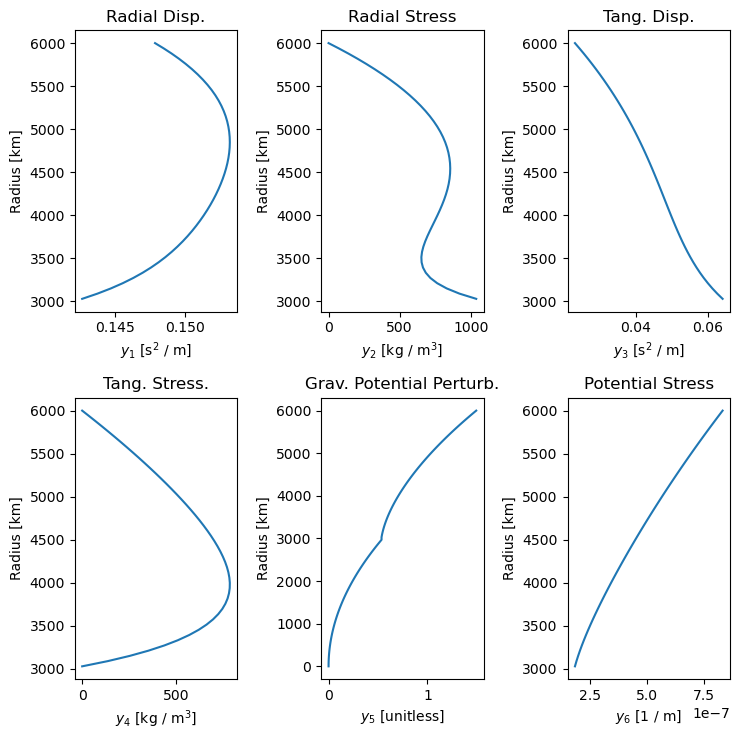

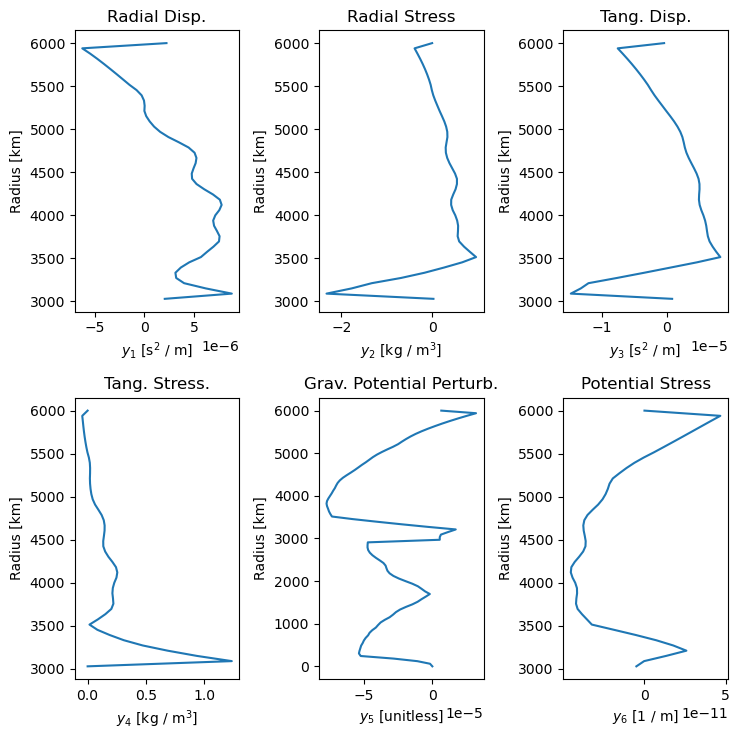

In [22]:
from TidalPy.radial_solver.numerical import radial_solver as radial_solver_old


out_old = radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-4,integration_atol = 1.0e-12,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - result.result), radius_array)

In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [25]:
# OLD (Not using NonDim):
# 144ms, 142ms
# New inputs
# 19.7ms; 19.6ms; 19.5ms
%timeit radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-4,integration_atol = 1.0e-12,nondimensionalize = False)

19.5 ms ± 99.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
# NEW (Not using NonDim):
# 1.31ms, 1.31ms
# 911us; 956us; 907us; 906us
%timeit radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = False,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = False,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = False,raise_on_fail = False)

906 µs ± 56.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Solid-Liquid-Solid

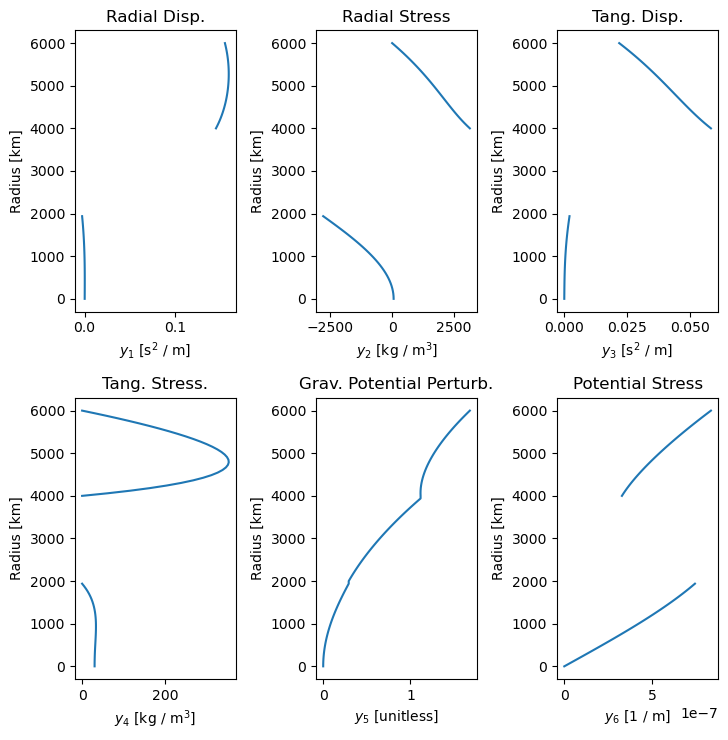

In [33]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
# frequency = 0.001
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)
ICB_radius = radius_array[-1] * (1/3)
CMB_radius = radius_array[-1] * (2/3)

IC_index = radius_array <= ICB_radius
OC_index = np.logical_and(radius_array > ICB_radius, radius_array <= CMB_radius)
mantle_index = radius_array > CMB_radius

density_array = np.empty_like(radius_array)
density_array[IC_index] = 11000.
density_array[OC_index] = 9000.
density_array[mantle_index] = 3950.

bulk_modulus_array = np.empty_like(radius_array)
bulk_modulus_array[IC_index] = 200.e9
bulk_modulus_array[OC_index] = 50.e9
bulk_modulus_array[mantle_index] = 100.e9

viscosity_array = np.empty_like(radius_array)
viscosity_array[IC_index] = 1.0e24
viscosity_array[OC_index] = 1000.
viscosity_array[mantle_index] = 1.0e18

shear_array = np.empty_like(radius_array)
shear_array[IC_index] = 100.0e9
shear_array[OC_index] = 0.
shear_array[mantle_index] = 50.0e9

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (True, False, True)
is_static_by_layer = (False, True, False)
is_incompressible_by_layer = (False, False, False)

indicies = (IC_index, OC_index, mantle_index)
upper_radius_by_layer = (ICB_radius, CMB_radius, radius_array[-1],)

solution = radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = False,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = False,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = False,raise_on_fail = False)

#_ = yplot(out[:, 0:N:2], radius_array[0:N:2])
_ = yplot(solution.result, radius_array)

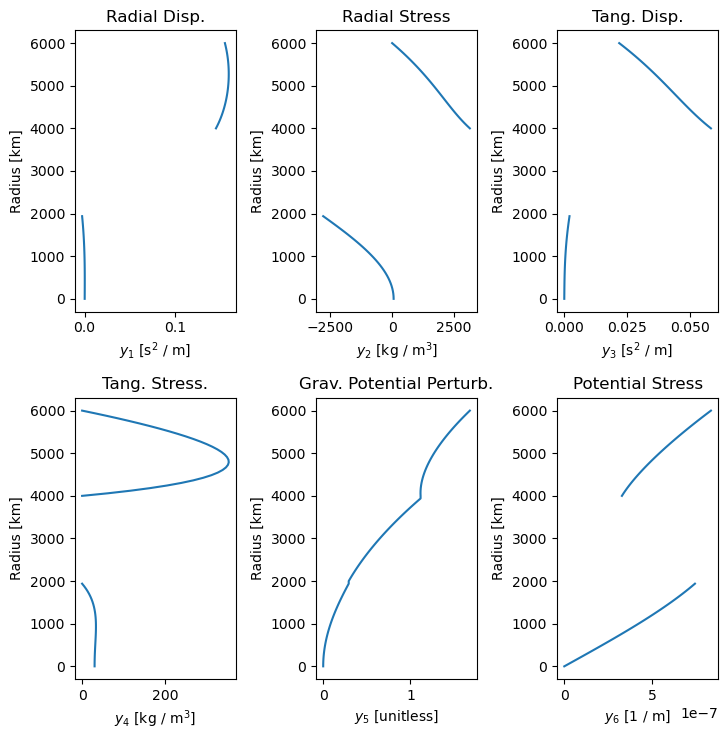

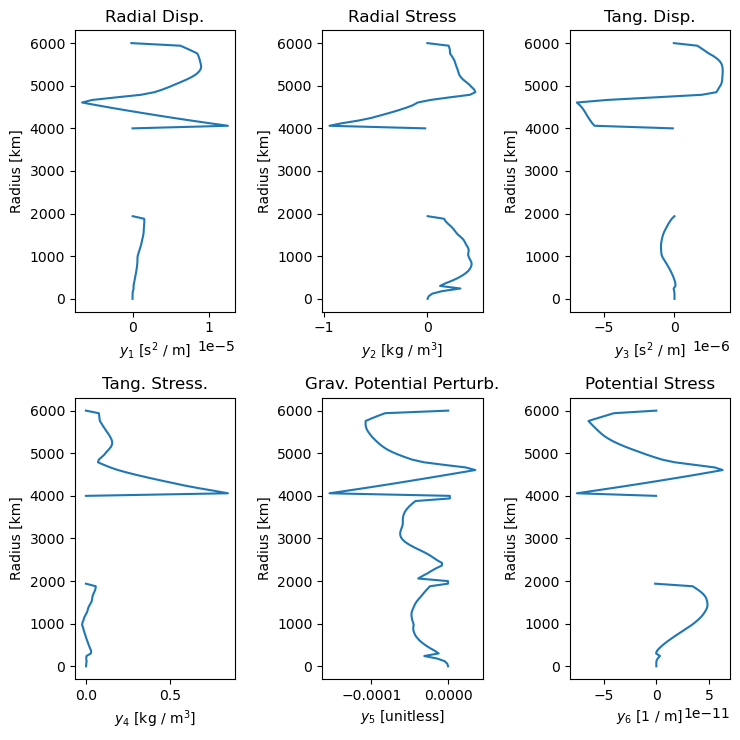

In [41]:
from TidalPy.radial_solver.numerical import radial_solver as radial_solver_old

out_old = radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-4,integration_atol = 1.0e-12,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - solution.result), radius_array)

In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [45]:
# OLD (Not using NonDim):
# 356ms, 353ms
# New inputs
# 49.7ms; 49.8ms; 49.8ms
%timeit radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-4,integration_atol = 1.0e-12,nondimensionalize = False)

49.8 ms ± 605 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
# NEW (Not using NonDim):
# 2.23ms, 2.28ms
# 1.59ms; 1.54ms; 1.72ms
%timeit radial_solver(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,solve_for = None,use_kamata = False,integration_method = 1,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = False,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,nondimensionalize = False,verbose = False,raise_on_fail = False)

1.72 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
